In [2]:
import dpkt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [15]:
def inet_2_ip(inet):
    return '.'.join(map(lambda x : str(x), inet))

In [17]:
# 细粒度 (IPD, Packet_Size)
def extract_pcap_s(filename, interval, src, dst):
    
    file = open(filename, 'rb')
    pcap_file = dpkt.pcap.Reader(file)
    packet_list = []
    for timestamp, buffer in pcap_file:
        eth = dpkt.ethernet.Ethernet(buffer)
        if not isinstance(eth.data, dpkt.ip.IP):
            print ('Non IP Packet type not supported %s\n' % eth.data.__class__.__name__)
            continue
        ip = eth.data
        if inet_2_ip(ip.src) == src and inet_2_ip(ip.dst) == dst:
            packet_list.append({'timestamp' : timestamp, 'size' : len(buffer)})
        elif inet_2_ip(ip.src) == dst and inet_2_ip(ip.dst) == src:
            packet_list.append({'timestamp' : timestamp, 'size' : -1*len(buffer)})
    file.close()
    print(len(packet_list))

    flow = []
    con_pkt = []
    pre_h_time = 0.0
    for i in range(len(packet_list)):
        time_size = []
        time = float(packet_list[i]['timestamp'])
        size = int(packet_list[i]['size'])
        if size > 0:
            ipd = time - pre_h_time
        else:
            ipd = -(time - pre_h_time)
        if float(time) > interval[1]:
            break
        if float(time) < interval[0]:
            continue
        if ipd == 0:
            con_pkt.append(size)
            continue
        if len(con_pkt) != 0:
            last_pkt = flow.pop()
            flow.append({"ipd": last_pkt["ipd"], "size": sum(con_pkt)+last_pkt['size']})
            con_pkt = []
        time_size.append (ipd)
        time_size.append(size)
        time_size = np.array (time_size)
        flow.append ({"ipd": time_size[0], "size": time_size[1]})
        pre_h_time = time

    ipd_list = []
    size_list = []
    
    for packet in flow:
        ipd_list.append(packet['ipd'])
        size_list.append(packet['size'])
    
    return [0.0] + ipd_list[1:] + size_list


In [18]:
file = open('../target&step.pcap', 'rb')
pcap_file = dpkt.pcap.Reader(file)
for timestamp, buffer in pcap_file:
    timestart = timestamp
    break
file.close()
timeend = timestart + 5.0
interval = (timestart, timeend)
src = '192.168.0.22'
dst = '114.248.0.100'
feature_list_AB = extract_pcap_s('../target&step.pcap', interval, src, dst)
src = '114.248.0.100'
dst = '114.248.1.100'
feature_list_BC = extract_pcap_s('../step&attack.pcap', interval, src, dst)

162673
152718


In [19]:
print(len(feature_list_AB), len(feature_list_BC))

11456 11306


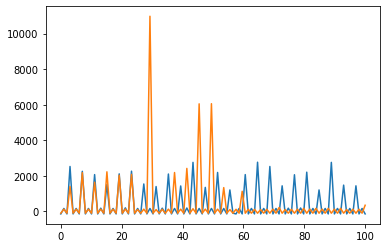

In [22]:
fig, ax = plt.subplots()
x = np.linspace(0,100,100)
curve_A = feature_list_AB[8000:8100]
curve_B = feature_list_BC[8000:8100]
ax.plot(x, curve_A, label='AB')
ax.plot(x, curve_B, label='BC')

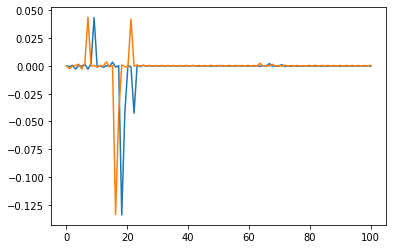

In [21]:
fig, ax = plt.subplots()
x = np.linspace(0,100,100)
curve_A = feature_list_AB[:100]
curve_B = feature_list_BC[:100]
ax.plot(x, curve_A, label='AB')
ax.plot(x, curve_B, label='BC')